In [1]:
%load_ext autoreload
%autoreload 2
import pynamod
import numpy as np
import io
import pandas as pd
import MDAnalysis as mda
import nglview as nv
import itertools
from numba import jit 
import torch
import copy
import h5py
from tqdm.auto import trange

from pynamod.energy.energy_constants import get_consts_olson_98,BDNA_step

from pynamod.external_forces.restraint import Restraint

/home/v_vasilev/.conda/envs/pynamod_env/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/v_vasilev/.conda/envs/pynamod_env/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


/home/v_vasilev/.conda/envs/pynamod_env/lib/python3.11/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
/home/v_vasilev/.conda/envs/pynamod_env/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [2]:
import warnings
warnings.filterwarnings('ignore')

### PDB Structure Analysis

In [42]:
nucl = pynamod.CG_Structure(pdb_id='3lz0')

Sending GET request to https://files.rcsb.org/download/3lz0.pdb to fetch 3lz0's pdb file as a string.


In [43]:
nucl.analyze_dna(leading_strands=['I'])

In [44]:
nucl.analyze_protein(nucl.u.select_atoms('protein'),n_cg_beads=150)

In [34]:
nucl.dna.step_params[70] += torch.ones(6)*100

In [46]:
nucl.dna.step_params = params

In [368]:
nucl.dna.move_to_coord_center()
cg_u = nucl.get_cg_mda_traj(allign_sel='segid P0')

RuntimeError: The size of tensor a (294) must match the size of tensor b (144) at non-singleton dimension 0

In [10]:
v = nv.show_mdanalysis(cg_u)
v

NGLWidget(max_frame=153)

In [35]:
nucl.view_structure()

NGLWidget()

In [11]:
v.clear()
v.add_representation('spacefill',radius =5)

In [70]:
for ts in nucl.dna.trajectory:
    print(nucl.dna.origins.mean())

tensor(-31.1984, dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
te

In [3]:
from pynamod.geometry.all_coords import All_Coords

In [12]:
All_Coords(nucl,100)[:80].origins.shape

torch.Size([130, 1, 3])

### Geom Params Testing

In [294]:
from pynamod.energy.energy_constants import BDNA_step

In [2]:
from pynamod.tests.bp_step_geometry import rebuild_by_full_par_frame_numba,rebuild_by_ori_and_mat

In [4]:
rebuild_by_ori_and_mat(nucl.dna.ref_frames.numpy(),nucl.dna.origins.reshape(-1,3).numpy())-nucl.dna.step_params.numpy()

NameError: name 'nucl' is not defined

In [293]:
from pynamod.geometry.geometrical_parameters import Geometrical_Parameters

In [295]:
linear = torch.tile(torch.DoubleTensor(BDNA_step[6:]),(200,1))

In [7]:
frames = rebuild_by_full_par_frame_numba(np.hstack([np.zeros((200,6)),linear.numpy()]))

/home/_shared/_projects/2024_pynamod_update/package/PyNAMod/pynamod/tests/bp_step_geometry.py:200: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  bp_frames[i,3,:3],bp_frames[i,:3,:3]=get_ori_and_mat_from_step_opt(params[0],params[1],params[2],
/home/_shared/_projects/2024_pynamod_update/package/PyNAMod/pynamod/tests/bp_step_geometry.py:200: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  bp_frames[i,3,:3],bp_frames[i,:3,:3]=get_ori_and_mat_from_step_opt(params[0],params[1],params[2],


In [296]:
linear_params = Geometrical_Parameters(local_params=linear)

In [ ]:
linear_params.local_params[4] += np.ones()

In [9]:
np.isclose(frames[:,3,:3],linear_params.origins.reshape(-1,3),atol=10e-13)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ T

In [14]:
np.sum(np.isclose(rebuild_by_ori_and_mat(frames[:,:3,:3],frames[:,3,:3]),linear,atol=10e-8),axis=0)

array([200,   0,   0, 200, 199,   0])

In [13]:
np.sum(np.isclose(Geometrical_Parameters(ref_frames=linear_params.ref_frames,origins=linear_params.origins).local_params.numpy(),rebuild_by_ori_and_mat(frames[:,:3,:3],frames[:,3,:3]),atol=10e-8),axis=0)

array([200,   1,   1,   1,  47,   1])

In [42]:
Geometrical_Parameters(ref_frames=linear_params.ref_frames,origins=linear_params.origins).local_params - linear

tensor([[ 0.0000e+00, -4.3600e-01, -3.3530e+00,  0.0000e+00, -1.7020e+00,
         -3.5666e+01],
        [ 6.9389e-18, -4.6674e-07,  3.4684e-05, -2.4904e-03, -1.8220e-06,
          0.0000e+00],
        [ 0.0000e+00, -9.9795e-06,  2.8601e-04,  1.1515e-02, -3.8957e-05,
         -7.1054e-15],
        ...,
        [ 1.3878e-17, -2.0071e-04,  1.4022e-03, -5.1637e-02, -7.8349e-04,
         -9.6634e-13],
        [-1.7764e-15, -1.7282e-04,  1.2987e-03, -4.7917e-02, -6.7464e-04,
         -1.1440e-12],
        [ 4.0246e-15, -9.8320e-05,  9.7129e-04,  3.6143e-02, -3.8381e-04,
         -1.1653e-12]], dtype=torch.float64)

In [106]:
def sl(slu):
    print(slu.step)

In [109]:
import pandas as pd

In [110]:
pd.DataFrame().loc

In [50]:
np.hstack([np.zeros((145,6)),nucl.dna.step_params.numpy()])

(145, 12)

In [52]:
np.isclose(rebuild_by_full_par_frame_numba(np.hstack([np.zeros((145,6)),nucl.dna.step_params.numpy()]))[:,:3,:3],nucl.dna.ref_frames.numpy(),atol=10e-14)

array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True, False],
        [ True, False,  True]],

       [[ True,  True, False],
        [ True,  True, False],
        [False,  True,  True]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False]]])

In [39]:
rebuild_by_ori_and_mat(nucl.dna.ref_frames.numpy(),nucl.dna.origins.reshape(-1,3).numpy())

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.47270649e-01, -1.62442833e+00,  3.48495532e+00,
        -2.42145661e-01,  3.88667954e+00,  2.42966660e+01],
       [ 4.31465537e-01, -8.12968095e-01,  3.19641857e+00,
         5.46101016e+00,  4.18257652e+00,  4.17889524e+01],
       [ 3.24251331e-01, -3.44761527e-01,  3.14588291e+00,
         5.38642183e+00,  1.08682760e+01,  3.32196207e+01],
       [-1.47744051e+00,  5.45518800e-01,  3.26075866e+00,
         6.72726764e-01,  1.17905158e+01,  2.93057775e+01],
       [-7.16053743e-01, -1.27459253e+00,  3.22722838e+00,
         2.15115836e+00,  1.75637250e+00,  2.56880617e+01],
       [ 1.49436751e+00,  6.16017063e-01,  2.79105290e+00,
         9.92852981e+00,  8.24665344e+00,  4.46928076e+01],
       [ 5.70522440e-01, -4.08480615e-02,  3.20131130e+00,
         5.49346806e+00,  6.87054767e+00,  3.06471576e+01],
       [-4.96852226e-01, -2.08374605e-01,  2.826

In [45]:
nucl.dna.step_params.numpy()

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.50868702e-01, -1.66416096e+00,  3.48505024e+00,
        -2.48270255e-01, -3.88629312e+00,  2.50909777e+01],
       [ 4.70165014e-01, -8.85709880e-01,  3.19722938e+00,
         6.87537356e+00, -2.14048489e-01,  4.68323327e+01],
       [ 3.40308432e-01, -3.61929207e-01,  3.14663198e+00,
         5.85921648e+00,  1.06208543e+01,  3.54358973e+01],
       [-1.53038722e+00,  5.65782117e-01,  3.26461738e+00,
         6.98779139e-01, -1.17890005e+01,  3.07626160e+01],
       [-7.34446478e-01, -1.30969423e+00,  3.23336811e+00,
         2.52882811e+00, -1.14776089e+00,  2.66373103e+01],
       [ 1.64230434e+00,  6.82889715e-01,  2.81359605e+00,
         1.25646635e+01, -2.95164848e+00,  5.12639306e+01],
       [ 5.92193110e-01, -4.24152535e-02,  3.21857637e+00,
         6.19465417e+00, -6.24570863e+00,  3.23367099e+01],
       [-5.22792962e-01, -2.18852985e-01,  2.842

In [40]:
params = nucl.dna.geom_params
ori = params.origins.clone()
ref_frames = params.ref_frames.clone()
step_params = params.local_params.clone()
params.local_params[:10] = torch.tile(torch.from_numpy(BDNA_step[6:]),(10,1))
print((ori != params.origins).sum(), (ref_frames != params.ref_frames).sum())
params.local_params = step_params

SyntaxError: invalid syntax (164857751.py, line 3)

In [48]:
params = nucl.geom_params
ori = params.origins.clone()
ref_frames = params.ref_frames.clone()
step_params = params.local_params.clone()
params.local_params[10] = torch.from_numpy(BDNA_step[6:])
print((ori != params.origins).sum(), (ref_frames != params.ref_frames).sum())
params.local_params = step_params

mod_Tensor(375) mod_Tensor(1125)


In [50]:
def test(dna_structure,test_steps=100001,compare_every=10000):
    frames = torch.clone(torch.from_numpy(dna_structure.base_ref_frames)).double()
    steps = torch.clone(torch.from_numpy(dna_structure.steps_params)).double()
    for i in trange(test_steps):
        change_step = torch.randint(2,30,(1,)).item()
        change = torch.rand((6,))-0.5
        steps[change_step] += change
        frames = rotate_bp_frames(frames,steps[change_step],change_step)
        if i%compare_every == 0:
            exp_frames = rebuild_base_ref_frames(steps,torch.zeros(frames.shape[0],4,4).double())
            dif = (exp_frames-frames)[-100:]
            print(torch.mean(abs(dif)[:,:3,:3]).item(),
                  torch.mean(torch.linalg.norm(dif[:,3,:3],dim=1)).item())
            

In [84]:
torch.eye(3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

### Linear Structure Generation

In [57]:
dna_gen = pynamod.CG_Structure()

In [58]:
dna_gen.build_dna(sequence='atcg'*7000)

In [64]:
nucl.append_structures((dna_gen,nucl,dna_gen,nucl,dna_gen,nucl,dna_gen,nucl,dna_gen,nucl,dna_gen,nucl,dna_gen,nucl,dna_gen,nucl,dna_gen,nucl,dna_gen,nucl))

In [59]:
%timeit change()

40.5 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
nucl.view_structure()

NGLWidget()

In [ ]:
dna_gen.view_structure()

In [22]:
cas = pynamod.CG_Structure(pdb_id='5Y36')

Sending GET request to https://files.rcsb.org/download/5Y36.pdb to fetch 5Y36's pdb file as a string.


In [23]:
cas = pynamod.CG_Structure(pdb_id='5Y36')
cas.analyze_dna(leading_strands=['C'],sel='(segid C or segid D) and not resid 24')
cas.analyze_protein()

Sending GET request to https://files.rcsb.org/download/5Y36.pdb to fetch 5Y36's pdb file as a string.


### Pytest

In [13]:
import pytest

In [14]:
!pytest pynamod --disable-warnings

============================= test session starts ==============================
platform linux -- Python 3.11.9, pytest-7.4.4, pluggy-1.0.0
rootdir: /home/_shared/_projects/2024_pynamod_update/package/PyNAMod
plugins: anyio-4.4.0
collecting ... ^C


### Quaternions

In [84]:
from pynamod.geometry.geometry_transformations import *

In [347]:
def quat_mult(a,b):
    res = np.zeros(a.shape)
    res[:,0] = a[:,0] * b[:,0] - a[:,1] * b[:,1] - a[:,2] * b[:,2] - a[:,3] * b[:,3]
    res[:,1] = a[:,0] * b[:,1] + a[:,1] * b[:,0] + a[:,2] * b[:,3] - a[:,3] * b[:,2]
    res[:,2] = a[:,0] * b[:,2] - a[:,1] * b[:,3] + a[:,2] * b[:,0] + a[:,3] * b[:,1]
    res[:,3] = a[:,0] * b[:,3] + a[:,1] * b[:,2] - a[:,2] * b[:,1] + a[:,3] * b[:,0]
    
    return(res)

In [358]:
def quat_mult_old(q1,q2):
    prod = np.zeros(q1.shape)
    prod[:,0] = q2[:,0]*q1[:,0] - np.sum(q1[:,1:]*q2[:,1:],axis=1)
    prod[:,1:] = q2[:,0].reshape(-1,1)*q1[:,1:] + q1[:,0].reshape(-1,1)*q2[:,1:] + np.cross(q1[:,1:],q2[:,1:])
    return prod


def rotate_old(quat,v):
    u = quat[:,1:]
    rot = 2*np.sum(u*v,axis=1).reshape(-1,1)*u 
    rot += (quat[:,0]**2 - np.linalg.norm(u,axis=1)**2).reshape(-1,1)*v
    rot += 2*quat[:,0].reshape(-1,1)*np.cross(u,v)
    return rot

def rotate(quat,v):
    conj = get_conj(quat)
    q_v = np.hstack([np.zeros((quat.shape[0],1)),v])
    prod = quat_mult(quat,q_v)
    return quat_mult(prod,conj)[:,1:]

def get_quat(phi,vec):
    phi = phi.reshape(-1,1)
    vec = np.tile(vec,phi.shape[0]).reshape(-1,3)
    quat = np.hstack([np.cos(phi/2),vec*np.sin(phi/2)])
    return quat

def get_conj(quat):
    return quat*[1,-1,-1,-1]

def normalize(quat):
    sin = np.sin(np.arccos(quat[:,0])).reshape(-1,1)
    vec = quat[:,1:]/sin
    quat[:,1:] /= np.linalg.norm(vec,axis=1).reshape(-1,1)
    return quat   

def quat_from_euler(a,b,g):
    cosa, sina = np.cos(a),np.sin(a)
    cosb, sinb = np.cos(b),np.sin(b)
    cosg, sing = np.cos(g),np.sin(g)
    q = np.zeros((cosa.shape[0],4))
    q[:,3] = cosb*cosa*sing + cosb*sina*cosg
    q[:,2] = sinb*cosa*cosg + sinb*sina*sing
    q[:,1] =  - sinb*cosa*sing + sinb*sina*cosg
    q[:,0] =  cosb*cosa*cosg - cosb*sina*sing
    return q

def rebuild_base_ref_frames_quat(steps_frames,bp_frames):
    steps_frames = np.copy(steps_frames)

    steps_frames[1:,3:] = np.deg2rad(steps_frames[1:,3:])
    z = np.array((0,0,1))
    y = np.array((0,1,0))


    gamma = np.linalg.norm(steps_frames[1:,3:5],axis=1)
    cos_phi =  steps_frames[1:,4]/gamma
    phi = np.arccos(cos_phi)
    phi[steps_frames[1:,3]<0] *= -1
    q1 = get_quat(steps_frames[1:,5]/2 - phi,z)
    qm = quat_mult(q1,get_quat(gamma/2,y))
    qm = quat_mult(qm,get_quat(phi,z))
    
    q2 = quat_mult(q1,get_quat(gamma,y))
    q2 = quat_mult(q2,get_quat(steps_frames[1:,5]/2 + phi,z))
    o2 = rotate(qm,steps_frames[1:,:3])
    bp_frames[0,:4] = [0,0,0,1]
    for i,q in enumerate(q2):
        bp_frames[i+1,:4] = quat_mult(bp_frames[i,:4].reshape(-1,4),q.reshape(-1,4))
    bp_frames[1:,4:] = np.cumsum(rotate(bp_frames[:-1,:4],o2),axis=1)
    
    return bp_frames

In [395]:
%timeit rebuild_base_ref_frames_quat(nucl.steps_params,np.zeros((145,7)))

3.19 ms ± 66.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [328]:
def rebuild_base_ref_frames(steps_frames,bp_frames):
    steps_frames = np.copy(steps_frames)

    steps_frames[:,3:] = np.deg2rad(steps_frames[:,3:])


    gamma = np.linalg.norm(steps_frames[:,3:5],axis=1)
    cos_phi =  steps_frames[:,4]/gamma
    phi = np.arccos(cos_phi)
    phi[steps_frames[:,3]<0] *= -1
    phi[0] = 0
    rm = Rotation.from_euler('zyz',np.vstack([steps_frames[:,5]/2 - phi,gamma/2,phi]).T)

    r2 = Rotation.from_euler('zyz',np.vstack([steps_frames[:,5]/2 - phi,gamma,steps_frames[:,5]/2 + phi]).T)
    o2 = rm.apply(steps_frames[:,:3])
    print([Rotation.concatenate(r2[:i+1]).apply(o2[i]) for i in range(steps_frames.shape[0])])
    bp_frames[1:,3,:3] = np.cumsum([Rotation.concatenate(r2[:i+1]).apply(o2[i]) for i in range(steps_frames.shape[0])],axis=0).reshape(-1,3)
    
    return bp_frames

In [298]:
def to_quat(steps_params):
    frames = rebuild_by_full_par_frame_numba(steps_params)
    quat = Rotation.from_matrix(frames[:,:3,:3]).as_quat()
    #quat = np.hstack([quat[:,3].reshape(-1,1),quat[:,:3]])
    return np.hstack([quat,frames[:,3,:3]])

In [329]:
rebuild_base_ref_frames(nucl.steps_params,np.zeros((145,4,4)))

[array([[0., 0., 0.]]), array([[ 0.15491968, -0.81949604,  4.05682631],
       [ 0.34882837, -0.24074414,  4.1199241 ]]), array([[0.98870168, 0.21881135, 3.68855256],
       [0.4131591 , 1.05784006, 3.65254752],
       [0.59966788, 0.80051662, 3.69193729]]), array([[-0.497103  ,  0.31548947,  3.03442937],
       [-0.785352  ,  0.18535252,  2.98383532],
       [-0.57973863, -0.1057856 ,  3.0343235 ],
       [-0.10641292,  0.57856162,  3.03452621]]), array([[1.30283043, 0.15637777, 3.1161284 ],
       [0.73858061, 1.1537839 , 3.09117433],
       [0.87633943, 0.96390191, 3.1200961 ],
       [1.52852662, 1.28851047, 2.72679748],
       [0.8366943 , 0.47527646, 3.24131644]]), array([[-0.81750902,  0.14122756,  3.52859044],
       [-0.96836273, -0.10810587,  3.49138991],
       [-0.70474814, -0.45059825,  3.52696867],
       [-0.21878177,  0.36588591,  3.59964981],
       [-0.95161605, -0.72282029,  3.42215933],
       [-1.05123827, -0.2561906 ,  3.45954928]]), array([[-0.19943887,  0.344655

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (145,) + inhomogeneous part.

In [359]:
(rebuild_base_ref_frames_quat(nucl.steps_params,np.zeros((145,7))) - to_quat(nucl.steps_params))[:,4:]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.39998887e-01,  2.20719909e+00,  9.93599823e-01],
       [-1.46666024e+00, -2.16109792e-01, -4.98027625e+00],
       [-6.12157595e-01,  2.42842048e+00, -6.83925442e+00],
       [ 1.22127285e-01, -8.22656704e-01, -1.16818430e+01],
       [-2.18406285e+00,  2.17526696e-01, -1.41883063e+01],
       [-2.64239924e+00,  5.77756701e-01, -1.76025630e+01],
       [-1.37827644e+00,  1.02082189e+00, -2.01212074e+01],
       [-2.64310140e+00,  1.23141324e+00, -2.37356118e+01],
       [-3.75815264e+00, -6.49411010e-02, -2.84917145e+01],
       [-4.93568434e+00,  5.33462644e-01, -3.08101974e+01],
       [-5.92820007e+00, -4.04191749e+00, -3.61759647e+01],
       [-6.80514920e+00, -9.55954205e-01, -3.67637157e+01],
       [-8.99754119e+00, -3.86613721e+00, -4.18438833e+01],
       [-9.58817083e+00, -5.31326628e+00, -4.47916615e+01],
       [-1.35625044e+01, -5.58463017e+00, -4.74044505e+01],
       [-1.45420710e+01, -2.31270144e+00

### Integrator and time tests

In [60]:
en = pynamod.Energy(K_bend=1)
en.set_energy_matrices(nucl)

In [61]:
en.add_restraints(restraint_type='circular',CG_structure=nucl)

In [113]:
nucl = pynamod.CG_Structure(pdb_id='3lz0')
nucl.analyze_dna(leading_strands=['I'])
nucl.analyze_protein(nucl.u.select_atoms('protein'),n_cg_beads=150)
dna_gen = pynamod.CG_Structure()
dna_gen.build_dna(sequence='atcg'*7)
nucl.append_structures((dna_gen,nucl,dna_gen,nucl,dna_gen,nucl))

en = pynamod.Energy()
en.set_energy_matrices(nucl)
en.add_restraints(restraint_type='circular',CG_structure=nucl)
#en.add_restraints([pynamod.external_forces.restraint.Restraint(0,-1,0.005,torch.tensor(BDNA_step[6:]),torch.ones(6,dtype=torch.double)/10)])

Sending GET request to https://files.rcsb.org/download/3lz0.pdb to fetch 3lz0's pdb file as a string.


In [21]:
%timeit en.get_full_energy(intg.intg_all_coords)

60.1 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
en.get_full_energy(nucl.all_coords)

mod_Tensor([32102.7598])

In [59]:
%timeit en._get_elastic_energy(nucl.all_coords.local_params)

220 µs ± 48 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
file.close()

In [26]:
nucl = pynamod.CG_Structure()
nucl.build_dna(sequence='atcg'*3000)

en = pynamod.Energy(K_bend=1)
en.set_energy_matrices(nucl,ignore_neighbors=20)
en.add_restraints(restraint_type='circular_with_linear_restraint',CG_structure=nucl,scaling_factor=10)

In [6]:
from pynamod.geometry.trajectories import H5_Trajectory

In [6]:
traj.file.close()

NameError: name 'traj' is not defined

In [127]:
def change():
    nucl.dna.step_params[70] += torch.ones(6)

In [83]:
%timeit change()

rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
rotate
19 ms ± 864 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
traj = H5_Trajectory('CG_circular.h5',100,12000)

In [75]:
file.flush()

In [8]:
nucl.all_coords.trajectory = traj

In [27]:
intg = pynamod.Iterator(nucl,en,traj,sigma_rot=0.3,sigma_transl=0.3)
movable = torch.ones(intg.dna_structure.dna.ref_frames.shape[0],dtype=bool)
movable[0] = False
start = 0
for i in intg.dna_structure.proteins:
    stop = start + 145
    movable[start:stop] = False
    start = stop + 28

intg.run(movable,target_accepted_steps=1000,max_steps=1000000,device='cuda',KT=0.5,save_every=10,transfer_to_memory_every=10)

Steps:   0%|          | 0/1000000 [00:00<?, ?it/s]

Acceptance rate:   0%|          

interrupted!
accepted_steps 34


In [18]:
%timeit torch.linalg.qr(rf)

10.2 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
rf = intg.intg_all_coords.ref_frames.cpu()

In [22]:
%timeit intg._integration_step(0.5,2,10)

63 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [135]:
intg.change = intg.change.to('cpu')

In [141]:
intg.normal_scale = intg.normal_scale.to('cpu')

In [138]:
intg.intg_all_coords.local_params

mod_Tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.4499, -0.2451,  3.4379, -0.2872,  0.8887, 28.6683],
            [ 0.0900, -0.2500,  3.3400, -1.7000,  4.5000, 31.9000],
            ...,
            [ 0.0000, -0.5900,  3.3100,  0.0000,  1.1000, 29.3000],
            [ 0.0900, -0.2500,  3.3400, -1.7000,  4.5000, 31.9000],
            [ 0.0000,  0.4100,  3.3900,  0.0000,  5.4000, 36.1000]],
           dtype=torch.float64)

In [14]:
%timeit change()

14.9 ms ± 371 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [129]:
nucl.all_coords.local_params.device

device(type='cpu')

In [119]:
intg.intg_all_coords._auto_rebuild_sw = True

In [130]:
intg.intg_all_coords.origins.device

device(type='cuda', index=0)

In [106]:
change()

In [13]:
def change():
    intg.intg_all_coords.local_params[20] += torch.normal(mean=intg.normal_mean,std=intg.normal_scale,out=intg.change)
    torch.cuda.synchronize()

In [34]:
params,ref_frames,origins = nucl.all_coords.local_params,nucl.all_coords.ref_frames,nucl.all_coords.origins

In [35]:
params.shape

torch.Size([12000, 6])

In [31]:
%timeit intg.intg_all_coords.get_new_params_set(params,ref_frames,origins )

190 ms ± 33.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [98]:
intg.intg_all_coords.trajectory.origins_traj.shape

torch.Size([1, 12000, 1, 3])

In [143]:
nucl.all_coords.trajectory.cur_step = 50

In [144]:
nucl.view_structure()

NGLWidget()

In [138]:
nucl.origins

<HDF5 dataset "origins": shape (100, 12000, 1, 3), type "<f4">

In [ ]:
en.restraints = []
en.add_restraints(restraint_type='circular_with_elastic_restraint',CG_structure=nucl)
intg.run(movable,target_accepted_steps=100000,max_steps=1000000,device='cuda',KT=16,save_every=10)

Steps:   0%|          | 0/1000000 [00:00<?, ?it/s]

Acceptance rate:   0%|          

In [25]:
a = intg.change.to('cpu').numpy()

In [23]:
nucl.all_coords._origins_traj[:nucl.all_coords._cur_tr_step+1].shape

torch.Size([1084, 3600, 1, 3])

In [20]:
nucl.all_coords._cur_tr_step -= 1

In [27]:
nucl.all_coords.save_to_h5('circular_large.h5')

In [16]:
with h5py.File('test.h5', 'w') as f:
    ori_dset = f.create_dataset('origins_traj',data=nucl.all_coords._local_params_traj)

array([0.19984926, 0.20045018, 0.19991633, 0.50024146, 0.50126815,
       0.5012078 ], dtype=float32)

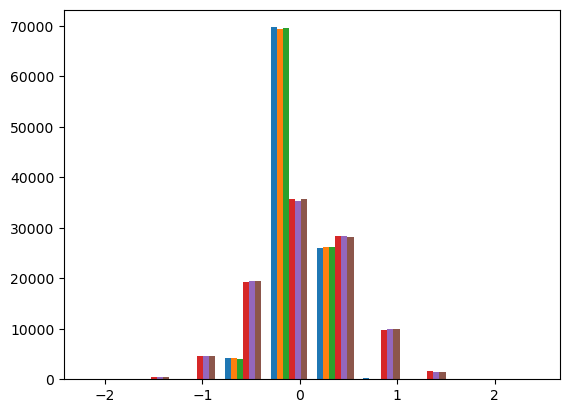

In [190]:
import matplotlib.pyplot as plt
plt.hist(a)
a.std(axis=0)

In [227]:
for i in nucl.dna.traj():
    print(en._get_elastic_energy(nucl.dna.step_params),
          en._get_real_space_total_energy(nucl.all_coords),
         en._get_restraint_energy(nucl))

mod_Tensor([364.7898], device='cuda:0') mod_Tensor([29.1947], device='cuda:0') mod_Tensor(1.9649e+09, device='cuda:0', dtype=torch.float64)
mod_Tensor([364.9436], device='cuda:0') mod_Tensor([29.2330], device='cuda:0') mod_Tensor(1.9631e+09, device='cuda:0', dtype=torch.float64)
mod_Tensor([367.0501], device='cuda:0') mod_Tensor([29.4947], device='cuda:0') mod_Tensor(1.9593e+09, device='cuda:0', dtype=torch.float64)
mod_Tensor([367.0750], device='cuda:0') mod_Tensor([29.4804], device='cuda:0') mod_Tensor(1.9584e+09, device='cuda:0', dtype=torch.float64)
mod_Tensor([367.8292], device='cuda:0') mod_Tensor([29.3337], device='cuda:0') mod_Tensor(1.9582e+09, device='cuda:0', dtype=torch.float64)
mod_Tensor([367.1301], device='cuda:0') mod_Tensor([29.2947], device='cuda:0') mod_Tensor(1.9572e+09, device='cuda:0', dtype=torch.float64)
mod_Tensor([368.0798], device='cuda:0') mod_Tensor([29.4278], device='cuda:0') mod_Tensor(1.9560e+09, device='cuda:0', dtype=torch.float64)
mod_Tensor([369.2170

In [125]:
intg.energies

[302.0912780761719,
 301.7518310546875,
 302.259521484375,
 302.81158447265625,
 303.02630615234375,
 303.2449645996094,
 303.99749755859375,
 304.2687683105469,
 304.44061279296875,
 305.2726135253906,
 305.30914306640625,
 305.69775390625,
 306.9950256347656,
 306.7090759277344,
 307.0456237792969,
 306.8060607910156,
 307.0336608886719,
 307.1568298339844,
 307.6278991699219,
 307.3529052734375,
 307.3689880371094,
 307.6390075683594,
 307.5344543457031,
 307.9776306152344,
 308.3618469238281,
 308.272705078125,
 309.3948059082031,
 310.08294677734375,
 310.21282958984375,
 310.7544250488281,
 310.3954162597656,
 311.2911376953125,
 311.59259033203125,
 311.7456970214844,
 312.58349609375,
 313.1336669921875,
 313.4276428222656,
 313.2772521972656,
 313.3990478515625,
 313.47802734375,
 313.0537414550781,
 313.32794189453125,
 313.9953308105469,
 314.4969787597656,
 315.9884948730469,
 315.8572998046875,
 316.0337219238281,
 316.91009521484375,
 317.28955078125,
 317.9575500488281,


In [132]:
intg.to('cpu')

In [16]:
u = nucl.get_cg_mda_traj()

In [25]:
u.atoms.write('bigtest.xtc',frames = u.trajectory[100:])
u.atoms.write('bigtest.pdb',frames = u.trajectory[100:101])

In [34]:
a = torch.zeros(6,dtype=torch.float).to('cuda')
a =torch.normal(mean=torch.zeros(6),std=torch.ones(6),out=a)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mean in method wrapper_CUDA_Tensor_Tensor_out_normal_out)

In [36]:
%timeit torch.zeros(6,device='cuda')

9.08 µs ± 137 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [26]:
v = nv.show_mdanalysis(mda.Universe('bigtest.pdb','bigtest.xtc'))
v.add_representation('spacefill',radius=10)
v

NGLWidget(max_frame=345)

In [43]:
import matplotlib.pyplot as plt

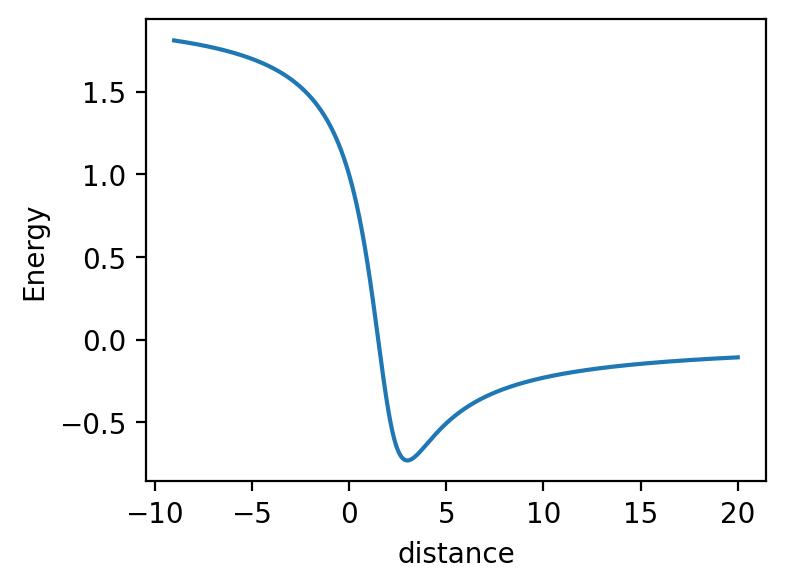

In [21]:
ignore_neighbors = np.arange(-9,20,0.001)
sg = 1-x/np.sqrt(2+(x - 2)**2)
plt.figure(figsize=(4,3),dpi=200)
plt.plot(x,sg)
plt.xlabel('distance')
plt.ylabel('Energy')
plt.show()

In [13]:
nucl2 = pynamod.CG_Structure()
nucl2.build_dna(sequence='atcg'*250)

en = pynamod.Energy(K_bend=1)
en.set_energy_matrices(nucl2,ignore_neighbors=8)
en.add_restraints(restraint_type='circular_with_linear_restraint',CG_structure=nucl2,scaling_factor=10)

In [5]:
intg = pynamod.Iterator(nucl,en,sigma_rot=0.3,sigma_transl=0.3)
movable = torch.ones(intg.dna_structure.dna.ref_frames.shape[0],dtype=bool)
movable[0] = False

In [97]:
nucl2.view_structure()

NGLWidget()

In [10]:
nucl.all_coords._local_params_traj.shape

torch.Size([1084, 3600, 6])

In [12]:
nucl.view_structure()

NGLWidget()

In [87]:
a = torch.ones(1,10000,3,dtype=torch.double)

In [115]:
sl = torch.triu(a).bool()

In [88]:
%timeit a.to('cuda')

77.2 µs ± 480 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [124]:
from seaborn import heatmap

<Axes: >

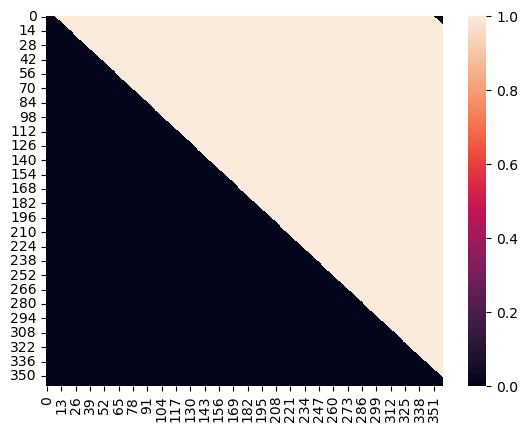

In [126]:
heatmap(en.dist_mat_slice)

In [9]:
from torch.profiler import profile, ProfilerActivity

In [10]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    for i in range(10):
        change()

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

STAGE:2025-03-09 10:46:22 52469:52469 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-03-09 10:46:25 52469:52469 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-03-09 10:46:25 52469:52469 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        aten::linalg_qr        41.07%        1.244s        98.89%        2.996s     748.922ms        1.340s        99.79%        2.003s     500.667ms             4  
void cutlass::Kernel<cutlass_80_tensorop_d884gemm_32...         0.00%       0.000us         0.00%       0.000us       0.000us     678.736ms        50.56%     678.736ms       7.081us         95850  
void cutl

In [7]:
torch.cuda.Device

typing.Union[int, str, torch.device, NoneType]

In [13]:
a = file.create_dataset('test',data=np.zeros((3,3)))

In [14]:
a

<HDF5 dataset "test": shape (3, 3), type "<f8">

In [ ]:
nucl = pynamod.CG_Structure(traj_len=50)
nucl.build_dna(sequence='atcg'*3000)

en = pynamod.Energy(K_bend=1)
en.set_energy_matrices(nucl,ignore_neighbors=20)
en.add_restraints(restraint_type='circular_with_linear_restraint',CG_structure=nucl,scaling_factor=10)

In [6]:
intg.run(movable,target_accepted_steps=50,max_steps=100000,device='cuda',KT=0.5,save_every=10)

Steps:   0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate:   0%|          

interrupted!
accepted_steps 26


In [29]:
def rotate(quat,vect):
    w = quat[:,0]
    v = quat[:,1:]
    ww = w * w
    xx = v[:,0] * v[:,0]
    yy = v[:,1] * v[:,1]
    zz = v[:,2] * v[:,2]
    wx = w * v[:,0]
    wy = w * v[:,1]
    wz = w * v[:,2]
    xy = v[:,0] * v[:,1]
    xz = v[:,0] * v[:,2]
    yz = v[:,1] * v[:,2]
    
    v= vect
    result = torch.zeros(3)
    result[0] = ww*v[0] + 2*wy*v[2] - 2*wz*v[1] +xx*v[0] + 2*xy*v[1] + 2*xz*v[2] - zz*v[0] - yy*v[0]
    result[1] = 2*xy*v[0] + yy*v[1] + 2*yz*v[2] + 2*wz*v[0] - zz*v[1] + ww*v[1] - 2*wx*v[2] - xx*v[1]
    result[2] = 2*xz*v[0] + 2*yz*v[1] + zz*v[2] - 2*wy*v[0] - yy*v[2] + 2*wx*v[1] - xx*v[2] + ww*v[2]

    return result

In [42]:
rotate(torch.tensor((1,0,0,0)),[1,1,1])

tensor([1., 1., 1.])

In [53]:
angle = np.pi/2
vect = np.array((0,0,1))

In [54]:
angle /= 2
quat = np.zeros(4)
quat[0] = np.cos(angle)
quat[1:] = vect*np.sin(angle)
rotate(quat,[1,1,1])

tensor([-1.,  1.,  1.])

In [32]:
from scipy.spatial.transform import Rotation as R

In [56]:
q = R.from_quat(np.append(quat[1:],quat[0]))

In [57]:
q.apply([1,1,1])

array([-1.,  1.,  1.])

In [41]:
np.cos(np.pi/2)

6.123233995736766e-17